# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vugtggus
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-vugtggus
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=c947878e719c68b36b504f4442f9fe593c437030d880727a371ac27650f21031
  Stored in directory: /tmp/pip-ephem-wheel-cache-likvserf/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"

Torch version: 2.0.1+cu118


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 46.3MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x78fb3306a4d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# CLIP Encoders

In [8]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [9]:
from torch import nn
import copy
from collections import OrderedDict

class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)

class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

In [12]:
class MyResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        ### Q1 TODO ###

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

        ###############

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):

        ### Q1 TODO ###

        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))

        ###############

        return x


In [13]:
attn_block = copy.deepcopy(model.visual.transformer.resblocks[0]).float().cpu()
my_block = MyResidualAttentionBlock(768, 12)
my_block.load_state_dict(attn_block.state_dict())

N, L, D = 4, 49, 768
x = torch.rand(L, N, D)
a = attn_block(x)
b = my_block(x)
attn_block(x).equal(my_block(x))

True

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [14]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

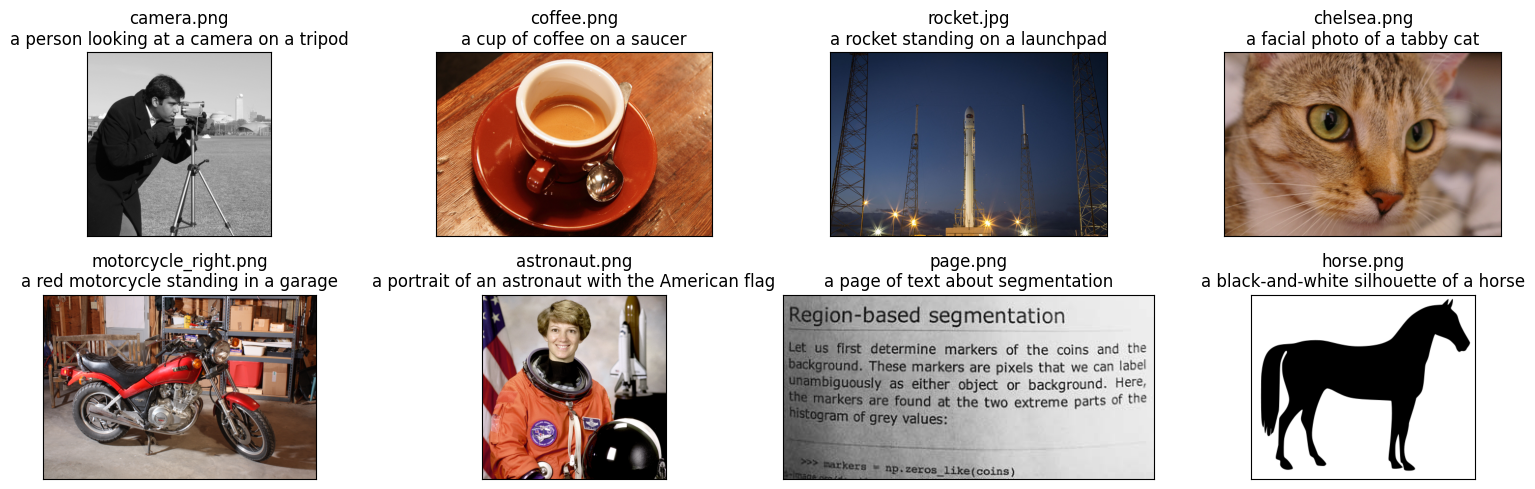

In [15]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [16]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [17]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [18]:
image_features.shape, text_features.shape

(torch.Size([8, 512]), torch.Size([8, 512]))

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [21]:
def get_similarity(image_features, text_features):

    ### Q2 TODO ###

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = image_features @ text_features.T
    similarity = similarity.cpu().numpy()

    ###############

    return similarity

similarity = get_similarity(image_features, text_features)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

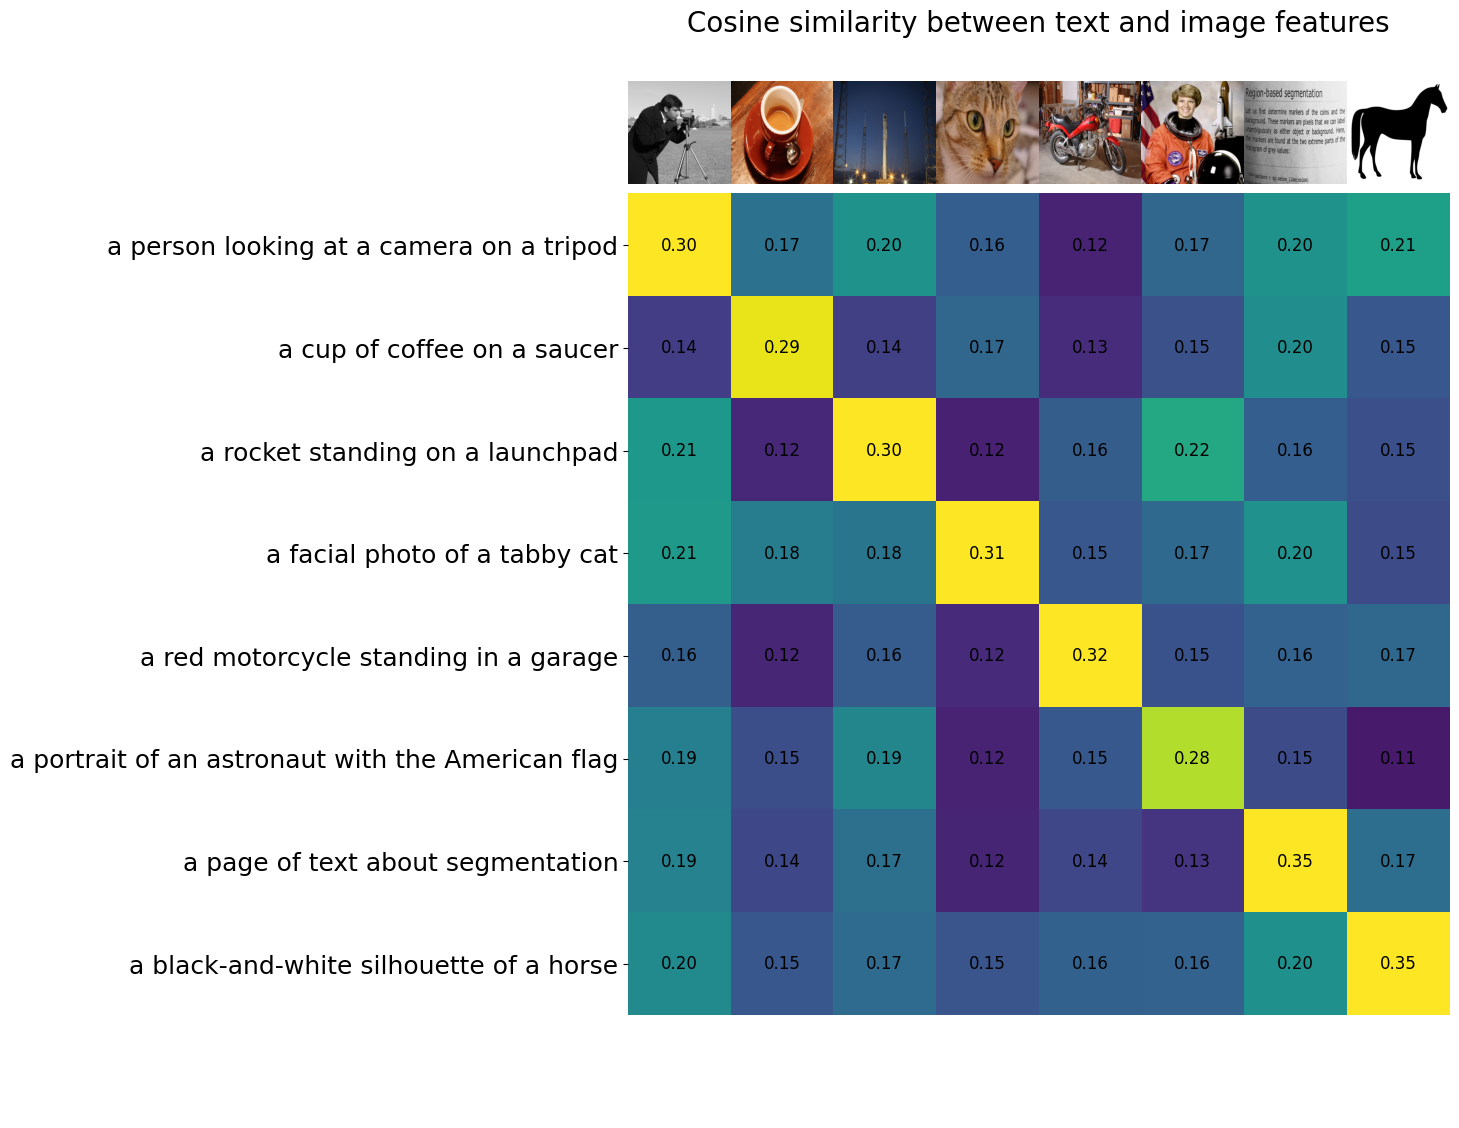

In [22]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Calculating contrastive loss

We normalize the features and calculate the InfoNCE loss within the 8 image-text pairs.

In [23]:
import torch.nn.functional as F

def InfoNCE(similarity):
    similarity = torch.from_numpy(similarity)
    n = similarity.shape[0]

    ### Q3 TODO ###

    labels = torch.arange(n)

    loss_i = F.cross_entropy(100 * similarity, labels)
    loss_t = F.cross_entropy(100 * similarity.T, labels)

    loss = (loss_i + loss_t) / 2

    ###############

    return loss

print(InfoNCE(similarity))
print(InfoNCE(similarity[:4, :4]))

tensor(0.0003)
tensor(4.3957e-05)


# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [24]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
cifar100_test = CIFAR100(os.path.expanduser("~/.cache"), train=False, transform=preprocess, download=True)

prompt = "this is a photo of a {}"
text_descriptions = [prompt.format(label) for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

100%|██████████| 169001437/169001437 [00:03<00:00, 48271327.85it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache
Files already downloaded and verified


In [25]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

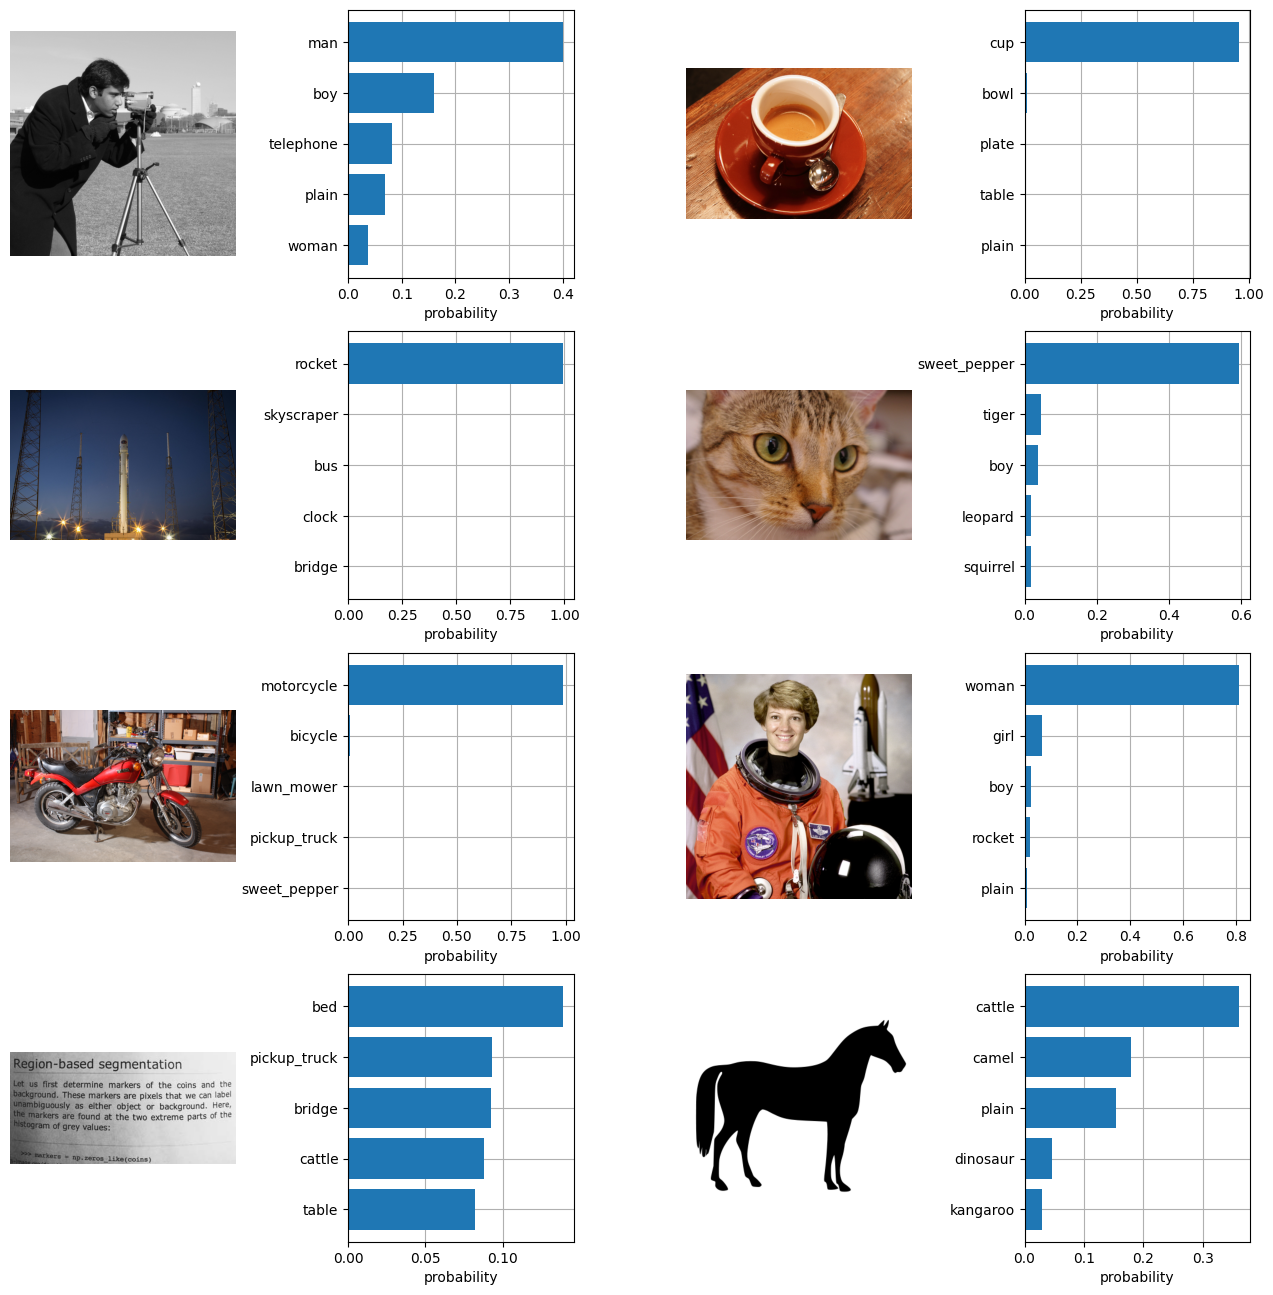

In [26]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Evaluate zero-shot CLIP on CIFAR 100

In [27]:
from torch.utils.data import DataLoader
import tqdm

target = cifar100.targets
target_test = cifar100_test.targets

train_loader = DataLoader(cifar100, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(cifar100_test, batch_size=16, shuffle=False, num_workers=0)

In [30]:
# prompt = "a photo of a {}"
prompt = "a picture of a {}"
text_descriptions = [prompt.format(label) for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

text_features = model.encode_text(text_tokens).float()
text_features /= text_features.norm(dim=-1, keepdim=True)

In [31]:
@torch.no_grad()
def evaluate():
    acc = 0.0
    num_samples = len(target_test)

    for batch in tqdm.tqdm(test_loader):
        input_image = batch[0].cuda()
        input_label = batch[1].cuda()

        ### Q4 TODO ###

        image_features = model.encode_image(input_image).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = image_features @ text_features.T

        ###############

        probs = (100.0 * similarity).softmax(dim=-1)

        top_label = torch.argmax(probs, dim=1)
        prediction = torch.eq(input_label, top_label)
        acc += prediction.sum()

    accuracy = acc / num_samples

    return accuracy.item()

print("Acc: , ", evaluate())

100%|██████████| 625/625 [00:23<00:00, 26.65it/s]

Acc: ,  0.6204000115394592


In [ ]:
# prompt emsemble
# https://github.com/openai/CLIP/blob/main/notebooks/Prompt_Engineering_for_ImageNet.ipynb

## Linear Probing

In [33]:
class LinearProbing(nn.Module):
    def __init__(self, num_classes=100):
        super(LinearProbing, self).__init__()
        self.fully_connected = nn.Linear(512, num_classes, bias=True)

    def forward(self, x):
        x = self.fully_connected(x)
        return x

lp_model = LinearProbing().cuda()

In [34]:
def train_one_epoch(train_loader):
    running_loss = 0.0
    last_loss = 0.0
    num_samples = len(cifar100)
    optimizer = torch.optim.SGD(lp_model.parameters(), lr=2e-2, momentum=0.9)

    for i, batch in tqdm.tqdm(enumerate(train_loader)):

        input_image = batch[0].cuda()
        input_label = batch[1]

        labels = torch.eye(100)[input_label].cuda()

        optimizer.zero_grad()

        ### Q5 TODO ###

        image_features = model.encode_image(input_image).float()

        outputs = lp_model(image_features)

        ###############

        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.0

    return last_loss

In [35]:
@torch.no_grad()
def evaluate_lp():
    acc = 0.0
    num_samples = len(target_test)

    for batch in tqdm.tqdm(test_loader):
        input_image = batch[0].cuda()
        input_label = batch[1].cuda()

        image_features = model.encode_image(input_image).float()
        #image_features /= image_features.norm(dim=-1, keepdim=True)

        outputs = lp_model(image_features)
        probs = outputs.softmax(dim=-1)

        top_label = torch.argmax(probs, dim=1)
        prediction = torch.eq(input_label, top_label)
        acc += prediction.sum()

    accuracy = acc / num_samples

    return accuracy.item()

print("Acc: , ", evaluate_lp())

100%|██████████| 625/625 [00:24<00:00, 25.70it/s]

Acc: ,  0.010199999436736107


In [36]:
epoch_number = 0
EPOCHS = 1

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))
    model.train(False)
    lp_model.train(True)
    avg_loss = train_one_epoch(train_loader)
    print(evaluate_lp())

EPOCH 1:


101it [00:08, 13.13it/s]

  batch 100 loss: 4.1540865278244015


203it [00:15, 15.03it/s]

  batch 200 loss: 3.0180511832237245


303it [00:22, 13.67it/s]

  batch 300 loss: 2.2861888754367827


403it [00:29, 15.17it/s]

  batch 400 loss: 1.8949132347106934


503it [00:36, 15.17it/s]

  batch 500 loss: 1.7331546902656556


601it [00:42, 14.92it/s]

  batch 600 loss: 1.574519052505493


703it [00:49, 14.89it/s]

  batch 700 loss: 1.5133506298065185


803it [00:56, 15.07it/s]

  batch 800 loss: 1.4273610299825668


903it [01:03, 14.94it/s]

  batch 900 loss: 1.3522795230150222


1001it [01:10, 12.06it/s]

  batch 1000 loss: 1.2940978050231933


1103it [01:17, 15.11it/s]

  batch 1100 loss: 1.2636544567346573


1201it [01:24, 15.13it/s]

  batch 1200 loss: 1.2037764829397202


1303it [01:31, 15.10it/s]

  batch 1300 loss: 1.2029492595791818


1403it [01:38, 14.69it/s]

  batch 1400 loss: 1.198750422000885


1501it [01:44, 15.15it/s]

  batch 1500 loss: 1.1974789321422576


1601it [01:52, 14.83it/s]

  batch 1600 loss: 1.0920749953389168


1701it [01:59, 11.77it/s]

  batch 1700 loss: 1.1025512635707855


1803it [02:06, 14.96it/s]

  batch 1800 loss: 1.0691012930870056


1901it [02:13, 14.53it/s]

  batch 1900 loss: 1.0830456736683844


2003it [02:20, 14.88it/s]

  batch 2000 loss: 1.117905419766903


2103it [02:27, 15.10it/s]

  batch 2100 loss: 0.9756750470399856


2201it [02:33, 13.63it/s]

  batch 2200 loss: 1.0262671792507172


2303it [02:41, 15.04it/s]

  batch 2300 loss: 0.9845598855614662


2403it [02:48, 12.89it/s]

  batch 2400 loss: 0.9979928621649742


2503it [02:55, 14.86it/s]

  batch 2500 loss: 1.0041294062137605


2603it [03:02, 14.86it/s]

  batch 2600 loss: 0.9397553636133671


2701it [03:08, 14.60it/s]

  batch 2700 loss: 0.9350986698269844


2803it [03:16, 14.95it/s]

  batch 2800 loss: 1.0175658068060875


2901it [03:22, 13.28it/s]

  batch 2900 loss: 0.9606106814742088


3001it [03:30, 11.83it/s]

  batch 3000 loss: 0.9467720538377762


3103it [03:37, 14.46it/s]

  batch 3100 loss: 0.9960698196291924


3125it [03:39, 14.24it/s]
100%|██████████| 625/625 [00:24<00:00, 25.47it/s]

0.7245000004768372


# Applications: ZegFormer

In [37]:
# Install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!git clone https://github.com/dingjiansw101/ZegFormer.git
%cd ZegFormer

import sys
sys.path.insert(0,'/content/ZegFormer')

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-d8bgo88k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-d8bgo88k
  Resolved https://github.com/facebookresearch/detectron2.git to commit 7d2e68dbe452fc422268d40ac185ea2609affca8
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6112356 sha256=c10489ee64a841460b5785171c21c4af

In [38]:
!pip install timm
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.3 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement scipy==1.7.0 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.7.2, 1.7.3, 1.8.0rc1, 1.8.0rc2, 1.8.0rc3, 1.8.0rc4, 1.8.0, 1.8.1, 1.9.0rc1, 1.9.0rc2, 1.9.0rc3, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.1

In [39]:
import argparse
import glob
import multiprocessing as mp
import os

# fmt: off
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
# fmt: on

import tempfile
import time
import warnings

import cv2
import numpy as np
import tqdm

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.utils.logger import setup_logger

from mask_former import add_mask_former_config
from demo.predictor import VisualizationDemo

In [60]:
import json
# lst = ["sky", "airplane", "road"]
lst = ["sky", "machine", "road"]
json.dump(lst, open("cls.json", "w"))

In [61]:
!wget http://images.cocodataset.org/val2017/000000005477.jpg -q -O input.jpg
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bA6DXr9VOMsRkU0vyY2EpGRkyQnhnze3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bA6DXr9VOMsRkU0vyY2EpGRkyQnhnze3" -O weights.pth && rm -rf ~/cookies.txt

--2023-08-25 07:06:46--  https://docs.google.com/uc?export=download&confirm=t&id=1bA6DXr9VOMsRkU0vyY2EpGRkyQnhnze3
Resolving docs.google.com (docs.google.com)... 74.125.199.139, 74.125.199.100, 74.125.199.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.199.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kf560hb9gevr02tkla66hqcjms494hhi/1692947175000/04074309113111608305/*/1bA6DXr9VOMsRkU0vyY2EpGRkyQnhnze3?e=download&uuid=8442e59b-cdee-4276-b7b3-2f57dffb216c [following]
--2023-08-25 07:06:46--  https://doc-0k-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kf560hb9gevr02tkla66hqcjms494hhi/1692947175000/04074309113111608305/*/1bA6DXr9VOMsRkU0vyY2EpGRkyQnhnze3?e=download&uuid=8442e59b-cdee-4276-b7b3-2f57dffb216c
Resolving doc-0k-3g-docs.googleusercontent.com (doc-0k-3g-docs.googleusercontent.com)... 173.194.202.132,

In [62]:
import atexit
import bisect
import multiprocessing as mp
from collections import deque

import cv2
import torch

from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from types import SimpleNamespace


class VisualizationDemo(object):
    def __init__(self, cfg, instance_mode=ColorMode.IMAGE, parallel=False):
        """
        Args:
            cfg (CfgNode):
            instance_mode (ColorMode):
            parallel (bool): whether to run the model in different processes from visualization.
                Useful since the visualization logic can be slow.
        """
        self.metadata = MetadataCatalog.get(
            cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
        )
        ns = SimpleNamespace()
        # ns.stuff_classes = demo.predictor.model.sem_seg_head.predictor.test_class_texts
        self.metadata = None
        self.cpu_device = torch.device("cpu")
        self.instance_mode = instance_mode

        self.predictor = DefaultPredictor(cfg)

        ns.stuff_classes = self.predictor.model.sem_seg_head.predictor.test_class_texts
        self.metadata = ns

    def run_on_image(self, image):
        """
        Args:
            image (np.ndarray): an image of shape (H, W, C) (in BGR order).
                This is the format used by OpenCV.
        Returns:
            predictions (dict): the output of the model.
            vis_output (VisImage): the visualized image output.
        """
        vis_output = None
        predictions = self.predictor(image)
        # Convert image from OpenCV BGR format to Matplotlib RGB format.
        image = image[:, :, ::-1]
        visualizer = Visualizer(image, self.metadata, instance_mode=self.instance_mode)
        vis_output = visualizer.draw_sem_seg(
                predictions["sem_seg"].argmax(dim=0).to(self.cpu_device)
            )


        return predictions, vis_output

In [63]:
import torch
import easydict
def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_mask_former_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)

    cfg.MODEL.SEM_SEG_HEAD.TRAIN_CLASS_JSON = "cls.json"
    cfg.MODEL.SEM_SEG_HEAD.TEST_CLASS_JSON = "cls.json"

    cfg.freeze()
    return cfg

def get_parser():
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin configs")
    parser.add_argument(
        "--config-file",
        default="configs/ade20k-150/maskformer_R50_bs16_160k.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument(
        "--input",
        nargs="+",
        default="input.png",
        help="A list of space separated input images; "
        "or a single glob pattern such as 'directory/*.jpg'",
    )
    parser.add_argument(
        "--output",
        default="./",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )

    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.5,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    return parser

args = easydict.EasyDict({"config_file": "configs/coco-stuff/zegformer_R101_bs32_60k_vit16_coco-stuff_gzss_eval.yaml",
                          "input": "input.png",
                          "output": "./",
                          "opts": ["MODEL.WEIGHTS", "weights.pth", "MODEL.MASK_FORMER.ENSEMBLING_ALL_CLS", "False", "MODEL.MASK_FORMER.ENSEMBLING", "False"]})
cfg = setup_cfg(args)
demo = VisualizationDemo(cfg)
demo.predictor.model.gzero_calibrate = -1.0

criterion.empty_weight
sem_seg_head.predictor.clip_model.ln_final.{bias, weight}
sem_seg_head.predictor.clip_model.token_embedding.weight
sem_seg_head.predictor.clip_model.transformer.resblocks.0.attn.out_proj.{bias, weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.0.attn.{in_proj_bias, in_proj_weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.0.ln_1.{bias, weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.0.ln_2.{bias, weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.0.mlp.c_fc.{bias, weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.0.mlp.c_proj.{bias, weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.1.attn.out_proj.{bias, weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.1.attn.{in_proj_bias, in_proj_weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.1.ln_1.{bias, weight}
sem_seg_head.predictor.clip_model.transformer.resblocks.1.ln_2.{bias, weight}
sem_seg_head.predictor

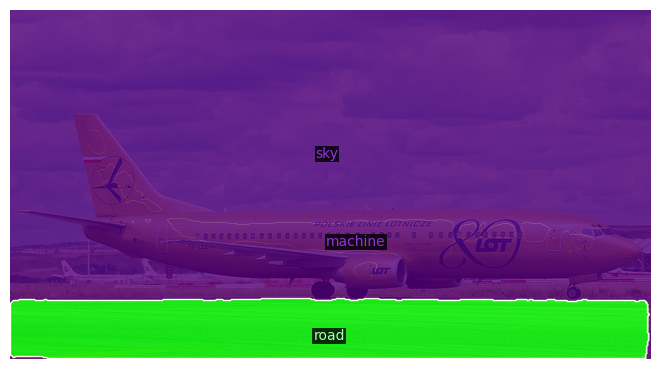

In [64]:
img = read_image("input.jpg", format="BGR")
predictions, visualized_output = demo.run_on_image(img)
visualized_output.fig